# Solution {-}

In [1]:
from sympy import Matrix, symbols, sqrt

xA, yA, xB, yB, r1, r2, x, xdot, y, ydot = symbols('xA, yA, xB, yB, r1 r2 x xdot y ydot')

# Measurement equation
r1 = sqrt((xA - x)**2 + (yA - y)**2)
r2 = sqrt((xB - x)**2 + (yB - y)**2)

# State vector
x = Matrix([[x],
            [xdot],
            [y],
            [ydot]])

H = Matrix([[r1],
            [r2]])
dH = H.jacobian(x)
display(dH)

Matrix([
[(x - xA)/sqrt((-x + xA)**2 + (-y + yA)**2), 0, (y - yA)/sqrt((-x + xA)**2 + (-y + yA)**2), 0],
[(x - xB)/sqrt((-x + xB)**2 + (-y + yB)**2), 0, (y - yB)/sqrt((-x + xB)**2 + (-y + yB)**2), 0]])

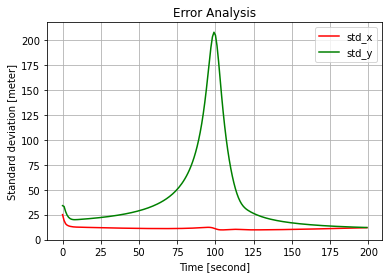

In [2]:
from numpy import array, exp, sqrt, arange, eye, kron, diag, zeros, column_stack
from numpy.linalg import inv, norm
from lib.vanloan import numeval
import matplotlib.pyplot as plt

dt = 1
samples = 200
d = 10000

# Initial standard deviation
sigmap = sqrt(2000)  # Position [meter]
sigmav = 30          # Velocity [meter/second]
sigmar = 15          # Range [meter]

# Gauss-Markov process parameters
beta = 0.01  # Time constant [rad/second]
sigma = 30   # [meter/second]

# DME station coordinates (x, y)
dme1 = [-10000, 0]
dme2 = [ 10000, 0]
dme = column_stack([dme1, dme2])  # Make columnvector

# Dynamic matrix (2D)
F0 = array([[0, 1],
            [0, -beta]])
F = kron(eye(2), F0)

# White noise coefficients (2D)
G0 = array([[0],
           [sqrt(2*sigma**2*beta)]])
G = kron(eye(2), G0)

# Numerical evaluation (Van Loan)
phi, Q = numeval(F, G, dt)

# Inital state covariance matrix
P0 = array([[sigmap**2, 0],
            [0, sigmav**2]])
P = kron(eye(2), P0)

# Initial measurement covariance matrix
R = sigmar**2*diag([2, 2])

# Linearized design matrix
def dH(xs, xnom):
    
    dH = zeros([2, 4])
    
    dx = xs - xnom
    
    dH[0] = [-dx[0, 0]/norm(dx[:, 0]), 1, -dx[1, 0]/norm(dx[:, 0]), 0]
    dH[1] = [-dx[0, 1]/norm(dx[:, 1]), 0, -dx[1, 1]/norm(dx[:, 1]), 1]
    
    return dH
    

# Initialize plot vectors
P_all = []

# Main loop
for k in range(0, samples):
    
    # Nominal trajectory
    xnom = array([[0],
                  [-10000 + 100*k]])
    
    H = dH(dme, xnom)
    
    # Time update
    Pp = phi@P@phi.T + Q
    
    # Design matrix
    #h11 = d/sqrt(d**2 + ynom**2)
    #h12 = ynom/sqrt(d**2 + ynom**2)
    #h21 = -d/sqrt(d**2 + ynom**2)
    #h22 = ynom/sqrt(d**2 + ynom**2)
    #
    #H = array([[h11, 1, h12, 0],
    #           [h21, 0, h22, 1]])
    
    # Measurement update
    K = Pp@H.T@inv(H@Pp@H.T + R)
    P = (eye(4) - K@H)@Pp
    
    # Accumulate plot vectors
    P_all.append(P)

# Time vector
time = arange(0, samples)

# Extract plot vectors
std_x = [sqrt(P[0, 0]) for P in P_all]  # Standard deviation x-direction
std_y = [sqrt(P[2, 2]) for P in P_all]  # Standard deviation y-direction

# Plot results
plt.title('Error Analysis')
plt.plot(time, std_x, 'r', label='std_x')
plt.plot(time, std_y, 'g', label='std_y')
plt.xlabel('Time [second]')
plt.ylabel('Standard deviation [meter]')
plt.legend()
plt.grid()
plt.show()

### Comment
The increase in variance in y-direction is due to the lack of observability of the y-component of from the range measurements close to the origin. However, the geometry of the x-component is good throughout the whole flight.